Image classification for chest xray dataset using pytorch

In [ ]:
import pandas as pd
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

In [ ]:
!unzip -q '/content/drive/My Drive/An_ComputerVision/ChestXRay2017.zip'

replace chest_xray/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
base_dir_path='/content/chest_xray'
train_dir_nm='train'
test_dir_nm='test'

In [ ]:
train_dir_path=os.path.join(base_dir_path,train_dir_nm)
train_dir_path

'/content/chest_xray/train'

In [ ]:
#check the files in train dir
os.listdir(train_dir_path)

['PNEUMONIA', 'NORMAL', '.DS_Store']

In [ ]:
test_dir_path=os.path.join(base_dir_path,test_dir_nm)
test_dir_path

'/content/chest_xray/test'

In [ ]:
 #check the files in test dir
os.listdir(test_dir_path)

['PNEUMONIA', 'NORMAL', '.DS_Store']

In [ ]:
test_dir_path=os.path.join(base_dir_path, test_dir_nm)
test_dir_path

'/content/chest_xray/test'

In [ ]:
os.listdir(test_dir_path)

['PNEUMONIA', 'NORMAL', '.DS_Store']

In [ ]:
dev=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dev

device(type='cuda')

In [ ]:
import torchvision.datasets as ds
import torchvision.transforms as tf

In [ ]:
tf_tr=tf.Compose([tf.RandomResizedCrop(512),tf.ToTensor()])
tf_tst=tf.Compose([tf.RandomResizedCrop(512),tf.ToTensor()])

In [ ]:
tr_imgs=ds.ImageFolder(train_dir_path, transform=tf_tr)
tst_imgs=ds.ImageFolder(test_dir_path, transform=tf_tst)

In [ ]:
tr_imgs
print(tr_imgs.classes)
print(tst_imgs.classes)

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


 To read the img tensor we need a data loader

In [ ]:
from torch.utils.data import DataLoader as dl

In [ ]:
tr_ldr=dl(tr_imgs,batch_size=10,shuffle=True)

In [ ]:
val_ldr=dl(tst_imgs,batch_size=10,shuffle=True)

 Now we will read the data and the label from the data loader

In [ ]:
for img, lbl in tr_ldr:
    print(img.shape)
    print(lbl.size(0))
    break

torch.Size([10, 3, 512, 512])
10


In [ ]:
import matplotlib.pyplot as plt

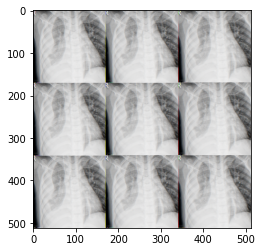

In [ ]:
for img, lbl in tr_ldr:
    #print(img[1].shape)
    plt.imshow(img[1].view(img[1].shape[1],img[1].shape[2],img[1].shape[0]))
    plt.show()
    break

Define the CNN architecture.
3 CNN modile followed by 1 maxpool and 2 FC layers

In [ ]:
import torch.nn as nn
import torch.nn.functional as f

In [ ]:
class Network (nn.Module):
     def __init__(self):
        super(Network,self).__init__()
        self.conv1=nn.Conv2d(3,16,3, padding=1)
        self.conv2=nn.Conv2d(16,32,3, padding=1)
        self.conv3=nn.Conv2d(32,64,3, padding=1)
        self.pool=nn.MaxPool2d(2,2)
        self.linear1=nn.Linear(64*64*64,256)
        self.linear2=nn.Linear(256,2)
     def forward(self, inp):
        for conv in [self.conv1,self.conv2,self.conv3]:
 
            inp=self.pool(f.relu(conv(inp)))
        #print(inp.shape)
        inp=inp.view(-1, inp.shape[1]*inp.shape[2]*inp.shape[3])
        #print(inp.shape)
        inp=f.relu(self.linear1(inp))
        inp=self.linear2(inp)
        return inp

In [ ]:
model=Network().to(dev)

Define the loss and optimizer

In [ ]:
import torch.optim as optim

In [ ]:
criterion=nn.CrossEntropyLoss()
optim=optim.Adam(model.parameters(), lr=.01)

In [ ]:
def model_eval(tr_ldr,val_ldr, model):
  epochs=20
  for e in range (epochs):
    tr_loss=[]
    val_loss=[]
    model.train()
    for data, lbl in tr_ldr:
      data=data.to(dev)
      lbl=lbl.to(dev)
      optim.zero_grad()
      out=model(data)
      loss=criterion(out, lbl.long())
      loss.backward()
      optim.step()
      del data, lbl, out
      torch.cuda.empty_cache() 
      tr_loss.append(loss.item())
    
    model.eval()
    total=0
    true=0
    for data1, lbl1 in val_ldr:
      data1=data1.to(dev)
      lbl1=lbl1.to(dev)
      out=model(data1)
      _, pred=torch.max(out.data,1)
      #loss=criterion(out, lbl1.long())
      #val_loss.append(loss)
      #print(out.shape)
      #print(lbl1.shape)
      total+=lbl1.size(0)
      true+=(pred==lbl1).sum().item()
      print(true)
  return tr_loss, (100*true)/total,model

In [ ]:
tr_loss,val_loss,model_best=model_eval(tr_ldr,val_ldr, model)

In [ ]:
cp={'state_dict': model_best.state_dict()}
torch.save(cp, 'Checkpoint.pth')

In [ ]:
val_loss

62.5

In [ ]:
import numpy as np

In [ ]:
np.mean(tr_loss)

0.5719888601025552